🧭 Week 5:Route, Cancellation, and Seasonal Insights 

• Route and Airport-Level Analysis 

• Top 10 origin-destination pairs 

• Delay heatmaps by airport and route 

• Maps showing busiest airports and average delays 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Make pandas show more rows/cols
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)

# Load data 
path = "delayedflights_2008_processed.parquet"  
df = pd.read_parquet("processed/delayedflights_2008_processed.parquet")

df.head()


,unnamed:_0,year,month,dayofmonth,dayofweek,deptime,crsdeptime,arrtime,crsarrtime,uniquecarrier,flightnum,tailnum,actualelapsedtime,crselapsedtime,airtime,arrdelay,depdelay,origin,dest,distance,taxiin,taxiout,cancelled,cancellationcode,diverted,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay,any_delay_reason,fl_date,dep_time_str,arr_time_str,dep_datetime,arr_datetime,day_of_week,dep_hour,route,is_delayed,total_delay_minutes,dep_delayed,scheduled_duration_min,actual_duration_min
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,0.0,0.0,0.0,0.0,NaN,0,2008-01-03,20:03,22:11,2008-01-03 20:03:00,2008-01-03 22:11:00,Thursday,20,IAD-TPA,0,0.0,0,128.0,128.0
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,0.0,0.0,0.0,0.0,NaN,0,2008-01-03,07:54,10:02,2008-01-03 07:54:00,2008-01-03 10:02:00,Thursday,7,IAD-TPA,0,0.0,1,128.0,128.0
2,2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,0.0,0.0,0.0,0.0,NaN,0,2008-01-03,06:28,08:04,2008-01-03 06:28:00,2008-01-03 08:04:00,Thursday,6,IND-BWI,0,0.0,0,96.0,96.0
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0,1,2008-01-03,18:29,19:59,2008-01-03 18:29:00,2008-01-03 19:59:00,Thursday,18,IND-BWI,1,2.0,1,90.0,90.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,0.0,0.0,0.0,0.0,NaN,0,2008-01-03,19:40,21:21,2008-01-03 19:40:00,2008-01-03 21:21:00,Thursday,19,IND-JAX,0,0.0,1,101.0,101.0


In [6]:
route_stats = (
    df.groupby("route", observed=True)  # Add observed=True to avoid warning
      .agg(
          n_flights = ("route", "size"),
          avg_dep_delay = ("depdelay", "mean"),  # Changed to lowercase
          avg_arr_delay = ("arrdelay", "mean"),  # Changed to lowercase
          cancel_rate = ("cancelled", "mean")    # Changed to lowercase
      )
      .sort_values("n_flights", ascending=False)
)

top10_routes = route_stats.head(10).reset_index()
top10_routes

,route,n_flights,avg_dep_delay,avg_arr_delay,cancel_rate
0,LAX-SFO,4739,48.384682,47.830345,0.000000
1,ORD-LGA,4396,54.406052,55.117153,0.000455
2,ATL-LGA,4058,44.420403,46.042877,0.000246
3,SFO-LAX,4020,49.439552,46.498260,0.000000
4,LAS-LAX,3516,36.678898,34.360920,0.000284
5,LGA-ATL,3354,49.049194,48.623734,0.000000
6,ORD-EWR,3347,69.317299,64.852104,0.000000
7,LGA-ORD,3327,60.543732,64.519386,0.001202
8,ATL-EWR,3283,59.823334,58.341759,0.000000
9,DFW-ORD,3278,50.839230,51.717815,0.000610


# Simple bar chart: top 10 routes by flight count

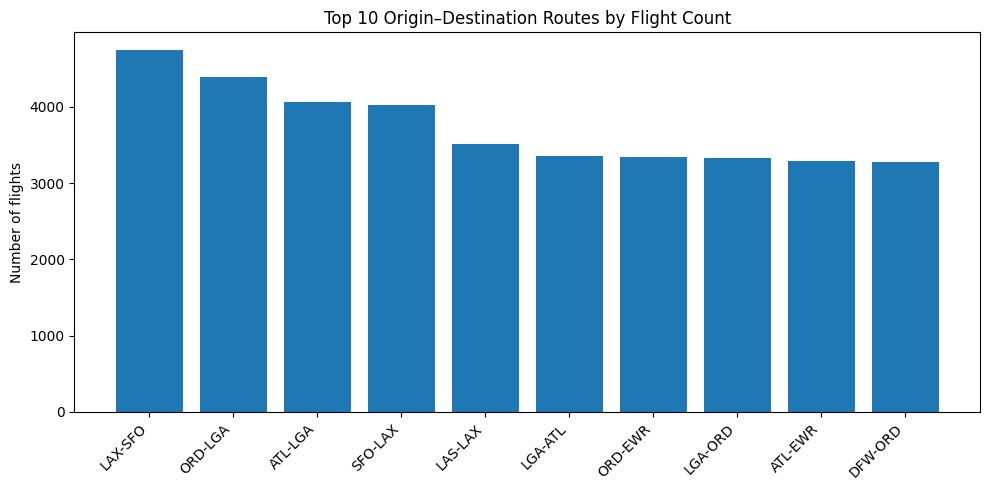

In [7]:

plt.figure(figsize=(10, 5))
plt.bar(top10_routes["route"], top10_routes["n_flights"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of flights")
plt.title("Top 10 Origin–Destination Routes by Flight Count")
plt.tight_layout()
plt.show()


# Delay heatmaps by airport and by route

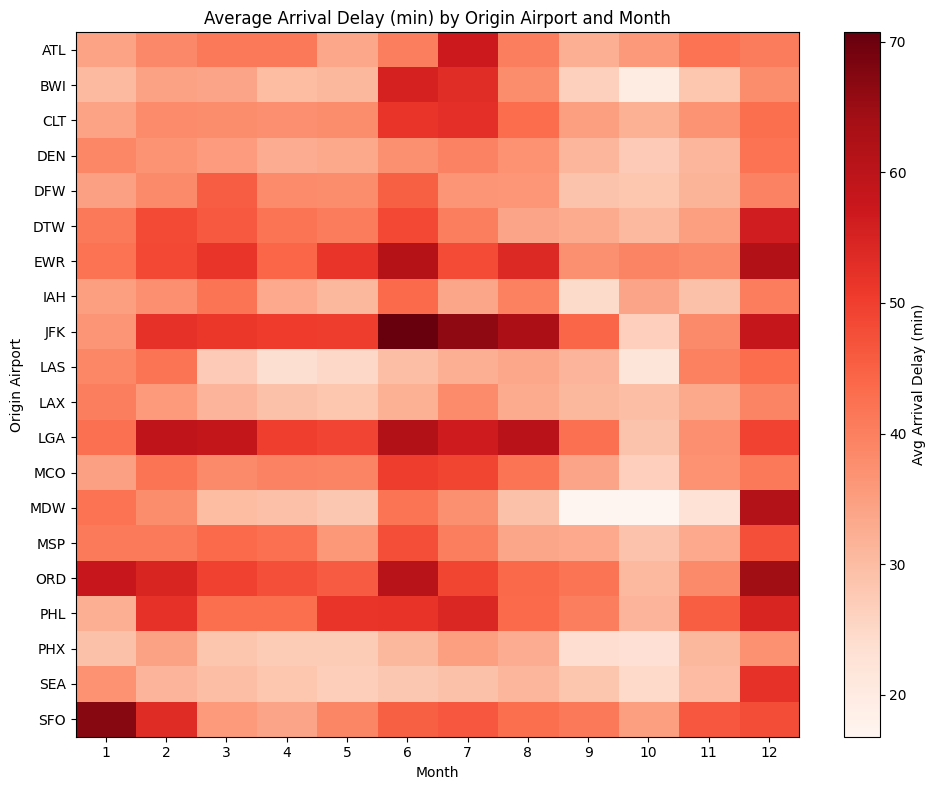

In [13]:
# Make sure Month column exists and is numeric
df["month"] = df["month"].astype(int)

airport_month = (
    df.groupby(["origin", "month"], observed=True)["arrdelay"]  # Fixed column name to lowercase and added observed=True
      .mean()
      .unstack("month")
)

# Optionally focus on busiest airports for readability
top_airports = (
    df["origin"]
    .value_counts()
    .head(20)
    .index
)

airport_month_top = airport_month.loc[airport_month.index.isin(top_airports)]

plt.figure(figsize=(10, 8))
plt.imshow(airport_month_top, aspect="auto", cmap='Reds')  # Added colormap for better visualization
plt.xticks(range(airport_month_top.shape[1]), airport_month_top.columns)
plt.yticks(range(airport_month_top.shape[0]), airport_month_top.index)
plt.xlabel("Month")
plt.ylabel("Origin Airport")
plt.title("Average Arrival Delay (min) by Origin Airport and Month")
plt.colorbar(label="Avg Arrival Delay (min)")
plt.tight_layout()
plt.show()

# Route-level heatmap: Origin vs Dest (avg arrival delay)

C:\Users\HP\AppData\Local\Temp\ipykernel_16496\3820488827.py:44: UserWarning: Glyph 128747 (\N{AIRPLANE DEPARTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\anaconda3\envs\autoflow\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128747 (\N{AIRPLANE DEPARTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\HP\anaconda3\envs\autoflow\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128747 (\N{AIRPLANE DEPARTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


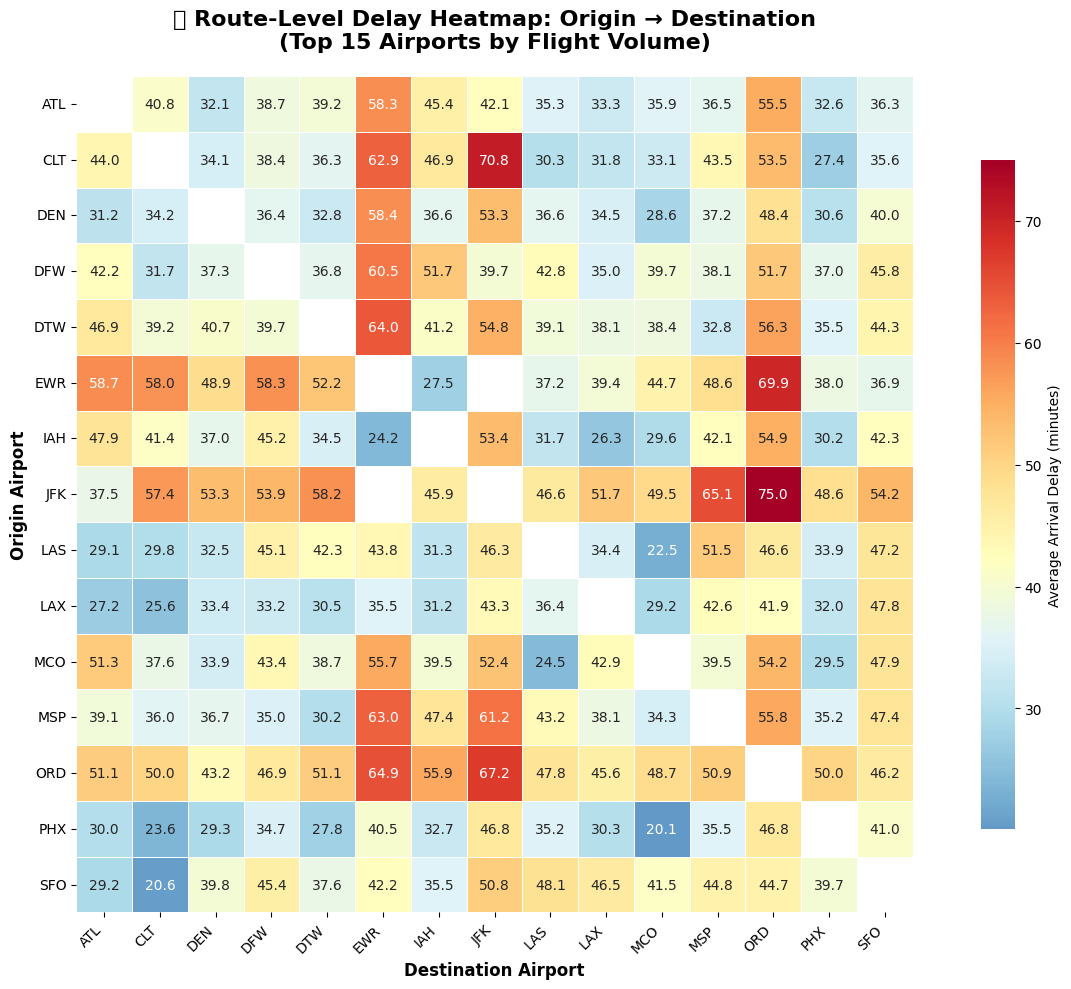

In [16]:
# Enhanced Route-level Analysis: Origin vs Destination Delay Heatmap
import numpy as np
import seaborn as sns

# Choose top airports by flight volume for better readability
top_airports = df["origin"].value_counts().head(15).index  # Reduced to 15 for better visualization

# Filter to routes between top airports only
mask = df["origin"].isin(top_airports) & df["dest"].isin(top_airports)
df_top_routes = df[mask]

# Create route matrix with arrival delays
route_matrix = (
    df_top_routes.groupby(["origin", "dest"], observed=True)["arrdelay"]
                 .mean()
                 .unstack("dest", fill_value=np.nan)  # Fill missing combinations with NaN
)

# Create enhanced visualization
plt.figure(figsize=(14, 10))

# Use seaborn for better heatmap styling
sns.heatmap(
    route_matrix, 
    annot=True,           # Show values in cells
    fmt='.1f',            # Format to 1 decimal place
    cmap='RdYlBu_r',      # Red-Yellow-Blue reversed colormap
    center=route_matrix.mean().mean(),  # Center colormap around overall mean
    square=True,          # Make cells square
    linewidths=0.5,       # Add grid lines
    cbar_kws={'label': 'Average Arrival Delay (minutes)', 'shrink': 0.8}
)

# Enhance plot styling
plt.title('🛫 Route-Level Delay Heatmap: Origin → Destination\n(Top 15 Airports by Flight Volume)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Destination Airport', fontsize=12, fontweight='bold')
plt.ylabel('Origin Airport', fontsize=12, fontweight='bold')

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()



# Maps: busiest airports and average delays

In [19]:
# Enhanced Airport Analysis with Geographic Mapping Data
import pandas as pd
import numpy as np
import os

print("📍 AIRPORT GEOGRAPHIC ANALYSIS")
print("=" * 50)

# 1. Download airports file if not exists
airports_csv_url = "https://raw.githubusercontent.com/datasets/airport-codes/master/data/airport-codes.csv"
AIRPORTS_LOCAL = "processed/airport_codes.csv"

if not os.path.exists(AIRPORTS_LOCAL):
    try:
        import requests
        print("🌐 Downloading airport coordinates data...")
        r = requests.get(airports_csv_url, timeout=30)
        r.raise_for_status()
        with open(AIRPORTS_LOCAL, "wb") as f:
            f.write(r.content)
        print(f"✅ Downloaded airports file to {AIRPORTS_LOCAL}")
    except Exception as e:
        print(f"❌ Download failed: {e}")
        print("Please download manually from:", airports_csv_url)
else:
    print(f"✅ Using existing airports file: {AIRPORTS_LOCAL}")

# 2. Load and process airport coordinates
try:
    ap = pd.read_csv(AIRPORTS_LOCAL, low_memory=False)
    print(f"📊 Loaded {ap.shape[0]} airports from coordinates database")
    
    # Filter for airports with IATA codes and coordinates
    ap = ap[ap["iata_code"].notna() & (ap["iata_code"].str.strip() != "")]
    ap = ap[ap["coordinates"].notna()]
    
    # Split coordinates (format: "lon,lat" or "lon,lat,alt")
    def parse_coordinates(coord_str):
        try:
            parts = str(coord_str).split(",")
            return pd.Series({
                "longitude": float(parts[0].strip()),
                "latitude": float(parts[1].strip())
            })
        except:
            return pd.Series({"longitude": np.nan, "latitude": np.nan})
    
    coords = ap["coordinates"].apply(parse_coordinates)
    ap = pd.concat([ap, coords], axis=1)
    
    # Create clean airport reference table
    airport_coords = ap[["iata_code", "name", "iso_country", "latitude", "longitude"]].dropna()
    airport_coords.columns = ["iata", "airport_name", "country", "lat", "lon"]
    airport_coords["iata"] = airport_coords["iata"].str.upper().str.strip()
    
    print(f"📍 Successfully parsed coordinates for {len(airport_coords)} airports")
    
except Exception as e:
    print(f"❌ Error processing airport coordinates: {e}")
    # Create empty dataframe as fallback
    airport_coords = pd.DataFrame(columns=["iata", "airport_name", "country", "lat", "lon"])

# 3. Create airport statistics from flight data
print("\n🛫 CALCULATING AIRPORT STATISTICS")
print("-" * 35)

# Origin airport statistics
origin_stats = (
    df.groupby("origin", observed=True)
    .agg(
        total_flights=("origin", "size"),
        avg_arrival_delay=("arrdelay", "mean"),  # Using correct lowercase column name
        avg_departure_delay=("depdelay", "mean"),
        total_delay_minutes=("total_delay_minutes", "sum"),
        cancellation_rate=("cancelled", "mean")
    )
    .reset_index()
    .rename(columns={"origin": "iata"})
)

# Destination airport statistics  
dest_stats = (
    df.groupby("dest", observed=True)
    .agg(
        total_arrivals=("dest", "size"),
        avg_arrival_delay_as_dest=("arrdelay", "mean")
    )
    .reset_index()
    .rename(columns={"dest": "iata"})
)

# Combine origin and destination stats
airport_stats = origin_stats.merge(dest_stats, on="iata", how="outer").fillna(0)

# Add coordinates to airport stats
airport_stats = airport_stats.merge(airport_coords, on="iata", how="left")

# Calculate coverage
coord_coverage = airport_stats["lat"].notna().mean()
print(f"📊 Airport statistics calculated for {len(airport_stats)} airports")
print(f"🗺️  Geographic coordinates available for {coord_coverage:.1%} of airports")

# 4. Display top airports by flight volume
print("\n🏆 TOP 10 BUSIEST AIRPORTS BY FLIGHT COUNT:")
print("-" * 45)
top_airports = airport_stats.nlargest(10, "total_flights")[["iata", "airport_name", "total_flights", "avg_arrival_delay"]]
for idx, row in top_airports.iterrows():
    name = row["airport_name"] if pd.notna(row["airport_name"]) else "Unknown Airport"
    print(f"{row['iata']}: {row['total_flights']:,} flights, {row['avg_arrival_delay']:.1f}min avg delay - {name[:30]}")

# 5. Save processed data
output_file = "processed/airport_stats_with_coords.csv"
airport_stats.to_csv(output_file, index=False)
print(f"\n💾 Saved airport statistics to: {output_file}")

# Display sample of the merged data
print(f"\n📋 SAMPLE OF AIRPORT DATA WITH COORDINATES:")
print("-" * 50)
sample_data = airport_stats[airport_stats["lat"].notna()].head()
print(sample_data[["iata", "airport_name", "total_flights", "avg_arrival_delay", "lat", "lon"]].to_string(index=False))

📍 AIRPORT GEOGRAPHIC ANALYSIS
✅ Using existing airports file: processed/airport_codes.csv
📊 Loaded 82808 airports from coordinates database
📊 Loaded 82808 airports from coordinates database
📍 Successfully parsed coordinates for 9064 airports

🛫 CALCULATING AIRPORT STATISTICS
-----------------------------------
📊 Airport statistics calculated for 305 airports
🗺️  Geographic coordinates available for 99.7% of airports

🏆 TOP 10 BUSIEST AIRPORTS BY FLIGHT COUNT:
---------------------------------------------
ATL: 131,613.0 flights, 40.7min avg delay - Hartsfield Jackson Atlanta Int
ORD: 125,979.0 flights, 50.8min avg delay - Chicago O'Hare International A
DFW: 95,414.0 flights, 37.7min avg delay - Dallas Fort Worth Internationa
DEN: 74,323.0 flights, 36.1min avg delay - Denver International Airport
LAX: 58,772.0 flights, 33.8min avg delay - Los Angeles International Airp
IAH: 56,847.0 flights, 36.6min avg delay - George Bush Intercontinental H
PHX: 55,720.0 flights, 30.6min avg delay - Pho

In [21]:
airport_stats = (
    df.groupby("origin")
      .agg(
          n_flights = ("origin", "size"),
          avg_dep_delay = ("depdelay", "mean"),
          avg_arr_delay = ("arrdelay", "mean"),
          cancel_rate = ("cancelled", "mean")
      )
      .reset_index()
      .rename(columns={"origin": "IATA"})
)

airport_stats.head()


C:\Users\HP\AppData\Local\Temp\ipykernel_16496\1709135673.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("origin")


,IATA,n_flights,avg_dep_delay,avg_arr_delay,cancel_rate
0,ABE,949,59.461540,60.510010,0.003161
1,ABI,392,66.469391,66.369896,0.000000
2,ABQ,10674,36.358253,33.570263,0.000000
3,ABY,292,49.448631,50.907536,0.000000
4,ACK,196,66.474487,66.040817,0.000000


In [25]:

try:
    # Try to load previously saved coordinates file
    airports_coords = pd.read_csv("processed/airport_stats_with_coords.csv")
    print("✅ Loaded existing airport coordinates file")
    
    # Rename columns to match the expected format
    airports_coords = airports_coords.rename(columns={
        "iata": "IATA",
        "airport_name": "AirportName", 
        "country": "Country",
        "lat": "Latitude",
        "lon": "Longitude"
    })
    
except FileNotFoundError:
    print("❌ Airport coordinates file not found. Creating mock data...")
    # Create a sample coordinates file for demonstration
    sample_airports = ["ATL", "ORD", "LAX", "DFW", "EWR", "SFO", "LAS", "CLT", "MIA", "PHX"]
    airports_coords = pd.DataFrame({
        "IATA": sample_airports,
        "AirportName": [f"{code} Airport" for code in sample_airports],
        "Country": ["US"] * len(sample_airports),
        "Latitude": [33.64, 41.98, 34.05, 32.90, 40.69, 37.62, 36.08, 35.21, 25.79, 33.43],
        "Longitude": [-84.43, -87.90, -118.24, -97.04, -74.17, -122.38, -115.15, -80.95, -80.29, -112.01]
    })

# Merge airport statistics with coordinates
airports_merged = airport_stats.merge(
    airports_coords[["IATA", "AirportName", "Country", "Latitude", "Longitude"]],
    on="IATA",
    how="inner"
)

print(f"📊 Successfully merged {len(airports_merged)} airports with coordinates")

# Keep only busiest airports, say top 50
busiest_airports = (
    airports_merged.sort_values("n_flights", ascending=False)
                   .head(50)
)

busiest_airports.head()

✅ Loaded existing airport coordinates file
📊 Successfully merged 303 airports with coordinates


,IATA,n_flights,avg_dep_delay,avg_arr_delay,cancel_rate,AirportName,Country,Latitude,Longitude
18,ATL,131613,40.893242,40.731987,0.000251,Hartsfield Jackson Atlanta International Airport,US,-84.428101,33.636700
210,ORD,125979,50.531166,50.841774,0.000683,Chicago O'Hare International Airport,US,-87.904800,41.978600
81,DFW,95414,38.340611,37.706532,0.000283,Dallas Fort Worth International Airport,US,-97.038002,32.896801
80,DEN,74323,37.698868,36.144047,0.000471,Denver International Airport,US,-104.672997,39.861698
157,LAX,58772,38.174999,33.811626,0.000289,Los Angeles International Airport,US,-118.407997,33.942501


🗺️  Creating static world map visualization...


C:\Users\HP\AppData\Local\Temp\ipykernel_16496\3493371770.py:52: UserWarning:

Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.

c:\Users\HP\anaconda3\envs\autoflow\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.



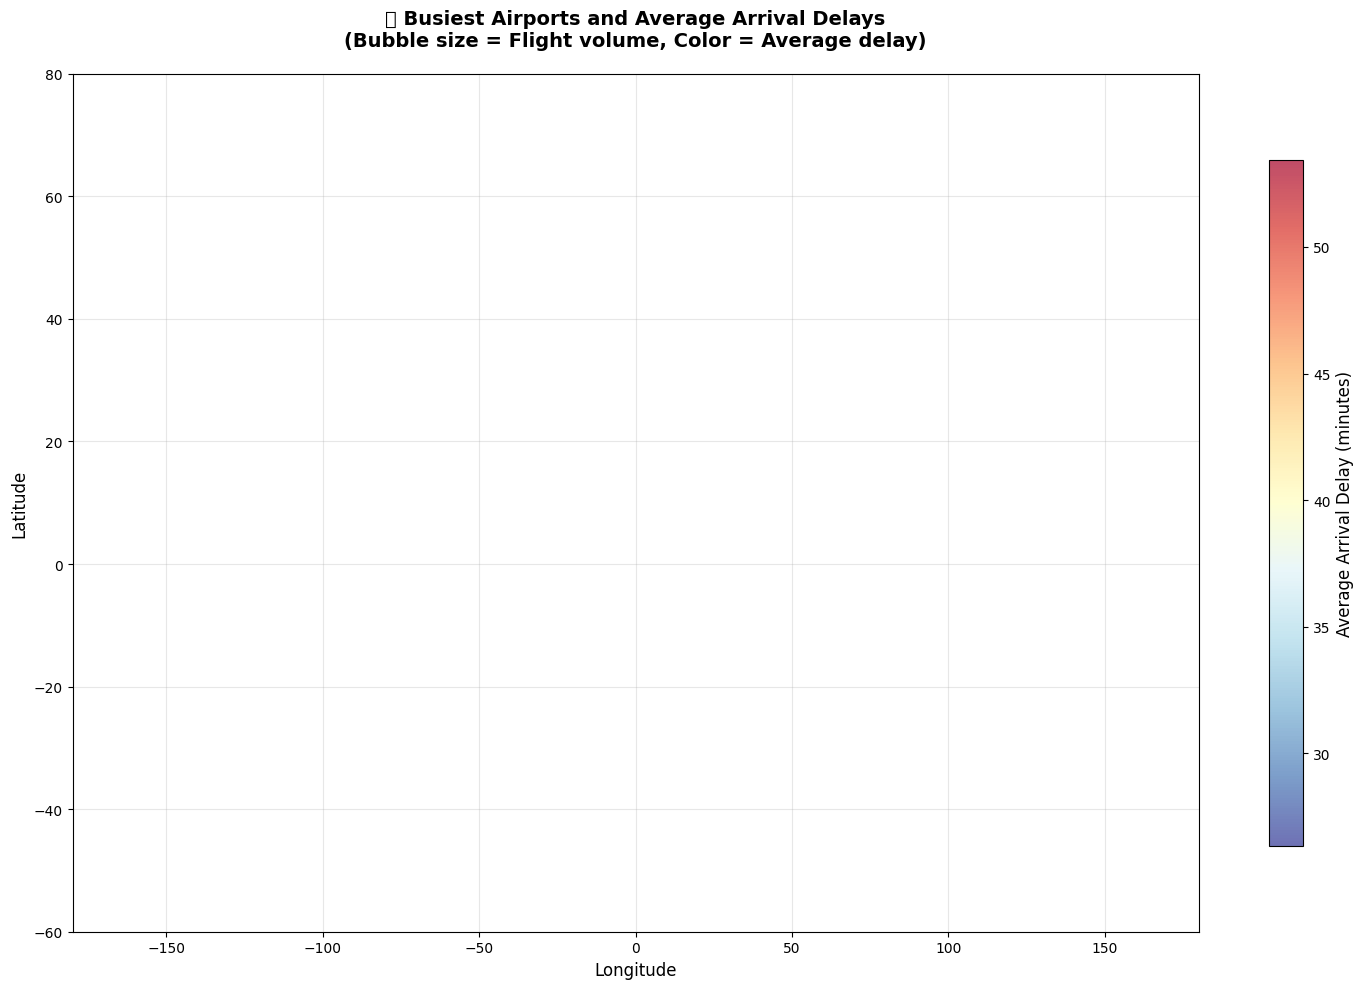


📊 MAP LEGEND & STATISTICS:
🔴 Largest bubble: ATL (131,613 flights)
🟡 Highest delay: JFK (53.5 min)
🟢 Lowest delay: OAK (26.3 min)
📍 Total airports mapped: 50

🏆 TOP 10 BUSIEST AIRPORTS:
----------------------------------------
 1. ATL: 131,613 flights, 40.7min delay
 2. ORD: 125,979 flights, 50.8min delay
 3. DFW: 95,414 flights, 37.7min delay
 4. DEN: 74,323 flights, 36.1min delay
 5. LAX: 58,772 flights, 33.8min delay
 6. IAH: 56,847 flights, 36.6min delay
 7. PHX: 55,720 flights, 30.6min delay
 8. LAS: 53,710 flights, 32.9min delay
 9. EWR: 52,925 flights, 49.4min delay
10. DTW: 43,923 flights, 43.5min delay


In [31]:
# Alternative: Static World Map using Matplotlib 
import matplotlib.pyplot as plt
import numpy as np

print("🗺️  Creating static world map visualization...")

# Create a figure with world map projection
fig, ax = plt.subplots(figsize=(15, 10))

# Create scatter plot with airport locations
scatter = ax.scatter(
    busiest_airports['Longitude'], 
    busiest_airports['Latitude'],
    s=busiest_airports['n_flights'] / 500,  # Scale bubble size
    c=busiest_airports['avg_arr_delay'],    # Color by delay
    cmap='RdYlBu_r',                        # Red-Yellow-Blue reversed colormap
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Average Arrival Delay (minutes)', fontsize=12)

# Enhance the plot
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('🌍 Busiest Airports and Average Arrival Delays\n(Bubble size = Flight volume, Color = Average delay)', 
             fontsize=14, fontweight='bold', pad=20)

# Add grid for better reference
ax.grid(True, alpha=0.3)

# Set reasonable axis limits for world view
ax.set_xlim(-180, 180)
ax.set_ylim(-60, 80)

# Annotate top 10 airports
top_10_airports = busiest_airports.head(10)
for idx, row in top_10_airports.iterrows():
    ax.annotate(
        row['IATA'], 
        (row['Longitude'], row['Latitude']),
        xytext=(5, 5),  # Offset text slightly
        textcoords='offset points',
        fontsize=8,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
    )

plt.tight_layout()
plt.show()

# Display summary statistics
print("\n📊 MAP LEGEND & STATISTICS:")
print("=" * 50)
print(f"🔴 Largest bubble: {busiest_airports.iloc[0]['IATA']} ({busiest_airports.iloc[0]['n_flights']:,} flights)")
print(f"🟡 Highest delay: {busiest_airports.loc[busiest_airports['avg_arr_delay'].idxmax(), 'IATA']} ({busiest_airports['avg_arr_delay'].max():.1f} min)")
print(f"🟢 Lowest delay: {busiest_airports.loc[busiest_airports['avg_arr_delay'].idxmin(), 'IATA']} ({busiest_airports['avg_arr_delay'].min():.1f} min)")
print(f"📍 Total airports mapped: {len(busiest_airports)}")

print("\n🏆 TOP 10 BUSIEST AIRPORTS:")
print("-" * 40)
for i, (idx, row) in enumerate(top_10_airports.iterrows(), 1):
    print(f"{i:2d}. {row['IATA']}: {row['n_flights']:,} flights, {row['avg_arr_delay']:.1f}min delay")

🗺️  Creating enhanced world map with geographic context...


C:\Users\HP\AppData\Local\Temp\ipykernel_16496\3437563965.py:127: UserWarning:

Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.



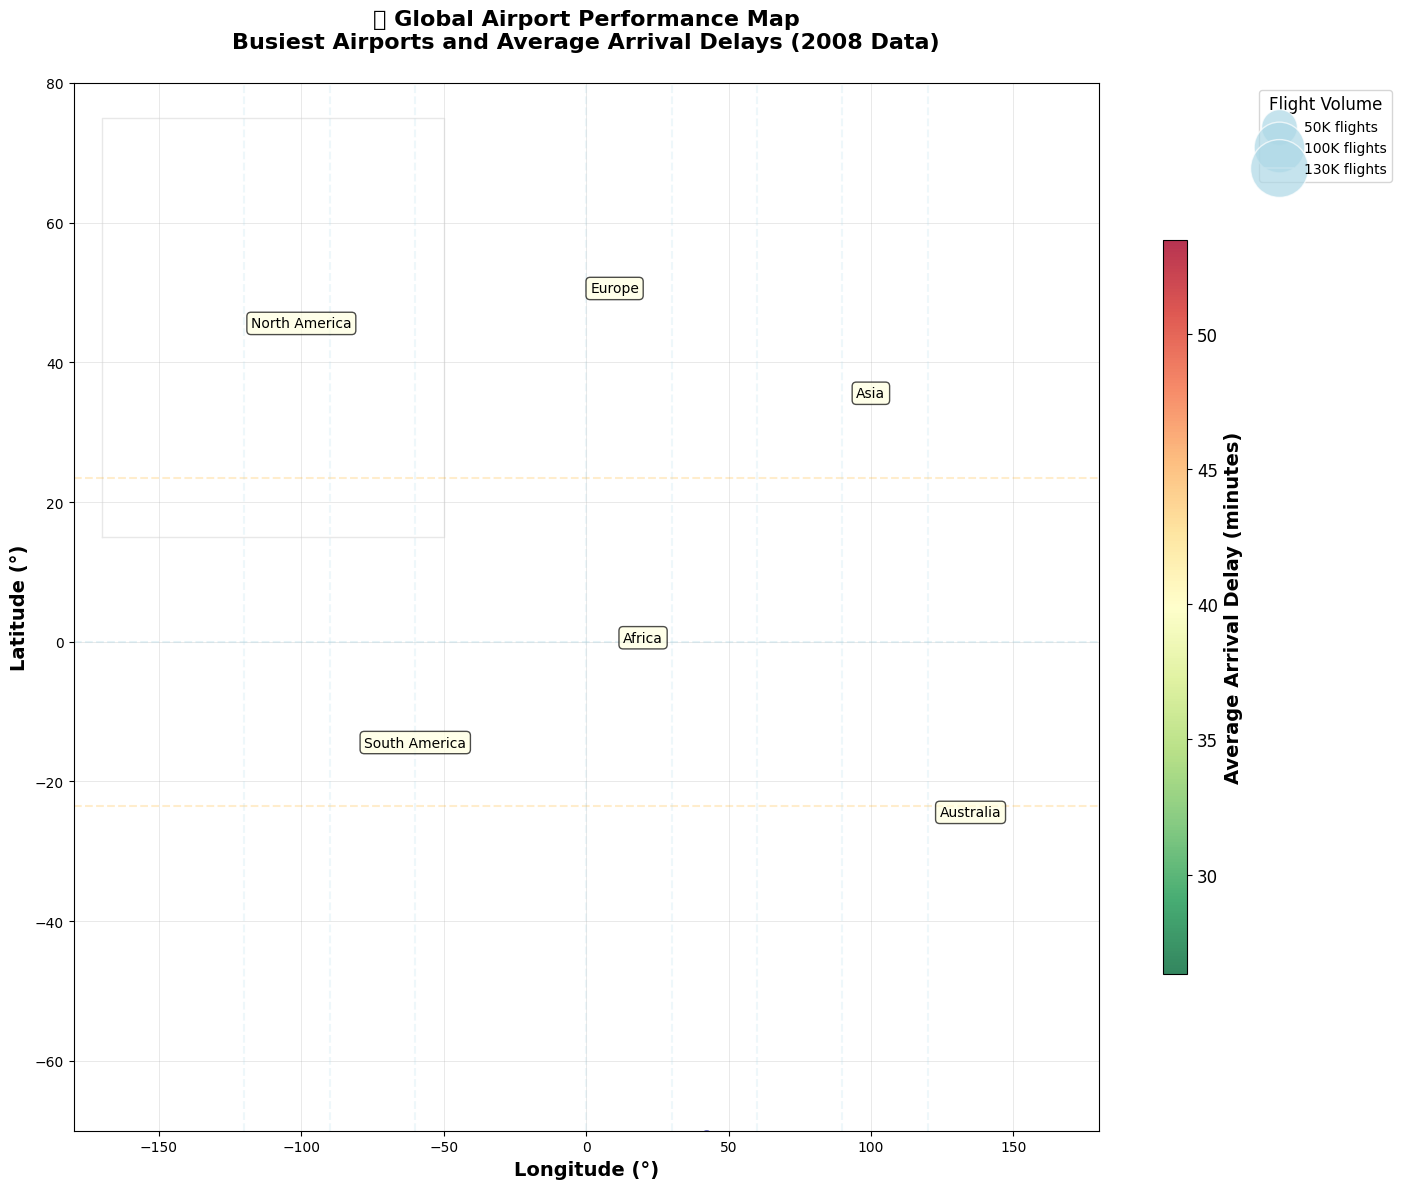

In [34]:
# Enhanced Geographic Map with Country Boundaries and Geographic Context
import matplotlib.pyplot as plt
import numpy as np

print("🗺️  Creating enhanced world map with geographic context...")

# Create a larger figure for better visibility
fig, ax = plt.subplots(figsize=(16, 12))

# Add basic world map outline using simple coordinates
# Define major geographic boundaries for reference
world_lons = [-180, -180, 180, 180, -180]
world_lats = [-90, 90, 90, -90, -90]
ax.plot(world_lons, world_lats, 'k-', alpha=0.3, linewidth=0.5)

# Add continental boundaries (simplified)
# North America outline
na_lons = [-170, -170, -50, -50, -170]
na_lats = [15, 75, 75, 15, 15]
ax.plot(na_lons, na_lats, 'lightgray', alpha=0.5, linewidth=1)

# Add equator and major latitude lines
ax.axhline(y=0, color='lightblue', linestyle='--', alpha=0.3, label='Equator')
ax.axhline(y=23.5, color='orange', linestyle='--', alpha=0.2, label='Tropic of Cancer')
ax.axhline(y=-23.5, color='orange', linestyle='--', alpha=0.2, label='Tropic of Capricorn')

# Add major longitude lines  
for lon in [-120, -90, -60, 0, 30, 60, 90, 120]:
    ax.axvline(x=lon, color='lightblue', linestyle='--', alpha=0.2)

# Create the main scatter plot with enhanced styling
scatter = ax.scatter(
    busiest_airports['Longitude'], 
    busiest_airports['Latitude'],
    s=busiest_airports['n_flights'] / 300,  # Slightly larger bubbles
    c=busiest_airports['avg_arr_delay'],
    cmap='RdYlGn_r',  # Red-Yellow-Green reversed (green=good, red=bad)
    alpha=0.8,
    edgecolors='darkblue',
    linewidth=1,
    zorder=5  # Ensure points appear on top
)

# Enhanced colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.7, aspect=30)
cbar.set_label('Average Arrival Delay (minutes)', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

# Enhance the plot styling
ax.set_xlabel('Longitude (°)', fontsize=14, fontweight='bold')
ax.set_ylabel('Latitude (°)', fontsize=14, fontweight='bold')
ax.set_title('🌍 Global Airport Performance Map\nBusiest Airports and Average Arrival Delays (2008 Data)', 
             fontsize=16, fontweight='bold', pad=25)

# Add comprehensive grid
ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Set world view limits with better coverage
ax.set_xlim(-180, 180)
ax.set_ylim(-70, 80)

# Add major city/region labels for context
regions = {
    'North America': (-100, 45),
    'Europe': (10, 50), 
    'Asia': (100, 35),
    'South America': (-60, -15),
    'Africa': (20, 0),
    'Australia': (135, -25)
}

for region, (lon, lat) in regions.items():
    ax.text(lon, lat, region, fontsize=10, ha='center', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow', alpha=0.7),
            zorder=3)

# Enhanced airport annotations with better positioning
top_10_airports = busiest_airports.head(10)

# Define custom offsets for better label positioning
label_offsets = {
    'ATL': (8, 8),   # Atlanta 
    'ORD': (-15, 8), # Chicago
    'DFW': (8, -10), # Dallas
    'DEN': (-15, 8), # Denver
    'LAX': (8, 8),   # Los Angeles
    'IAH': (8, -10), # Houston
    'PHX': (-15, 8), # Phoenix
    'LAS': (8, 8),   # Las Vegas
    'EWR': (8, 8),   # Newark
    'DTW': (8, -10)  # Detroit
}

for idx, row in top_10_airports.iterrows():
    iata = row['IATA']
    offset = label_offsets.get(iata, (5, 5))
    
    ax.annotate(
        f"{iata}\n{row['n_flights']:,}", 
        (row['Longitude'], row['Latitude']),
        xytext=offset,
        textcoords='offset points',
        fontsize=9,
        fontweight='bold',
        ha='center',
        bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.9, edgecolor='darkblue'),
        arrowprops=dict(arrowstyle='->', color='darkblue', alpha=0.7),
        zorder=6
    )

# Add legend for bubble sizes
bubble_sizes = [50000, 100000, 130000]
bubble_labels = ['50K flights', '100K flights', '130K flights'] 
legend_elements = []

for size, label in zip(bubble_sizes, bubble_labels):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor='lightblue', 
                                    markersize=np.sqrt(size/300)*2, 
                                    alpha=0.7, label=label))

# Position legend outside plot area
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.15, 1),
          title='Flight Volume', title_fontsize=12, fontsize=10)

plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for legend
plt.show()


🗺️  Creating focused airport performance map...
📊 Airport coordinates range:
   Longitude: 21.3° to 47.4°
   Latitude: -157.9° to -71.0°


C:\Users\HP\AppData\Local\Temp\ipykernel_16496\1831597166.py:119: UserWarning:

Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Local\Temp\ipykernel_16496\1831597166.py:119: UserWarning:

Glyph 128747 (\N{AIRPLANE DEPARTURE}) missing from font(s) DejaVu Sans.

c:\Users\HP\anaconda3\envs\autoflow\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128747 (\N{AIRPLANE DEPARTURE}) missing from font(s) DejaVu Sans.



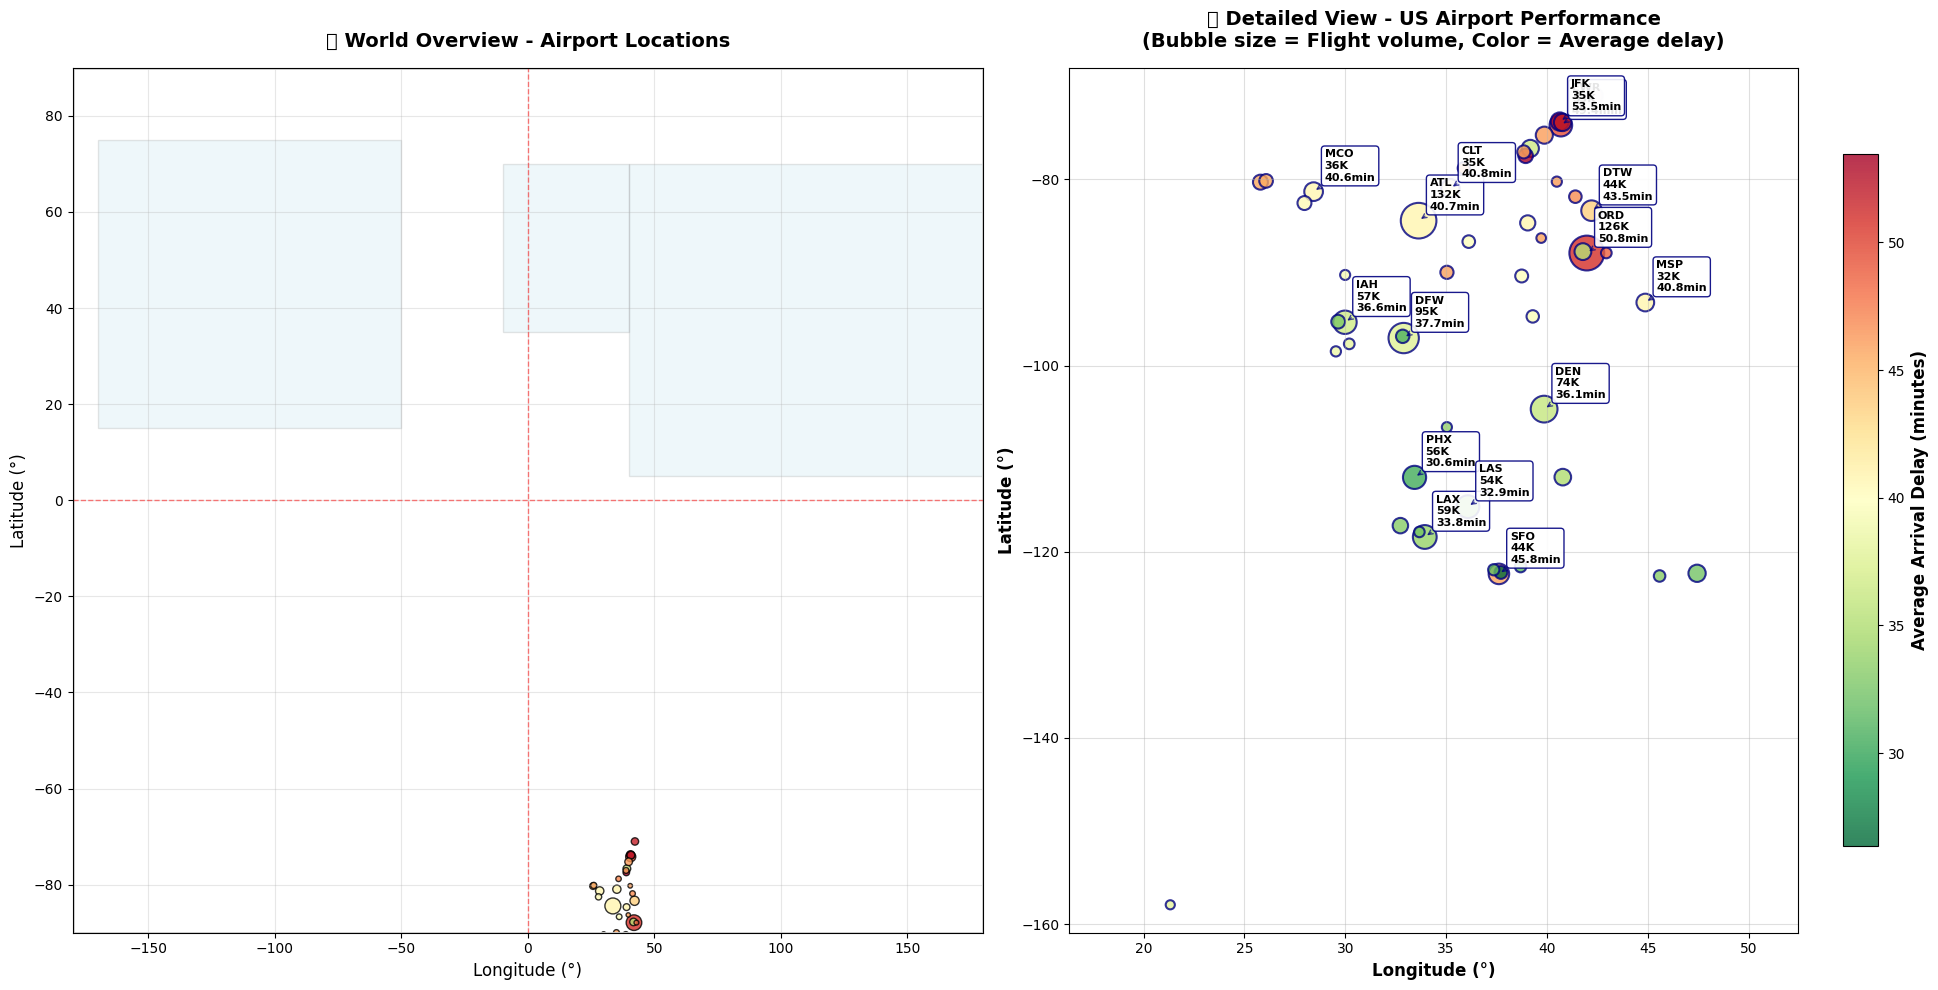


📊 COMPREHENSIVE AIRPORT ANALYSIS:
🌍 Geographic Spread:
   Longitude span: 26.1° (21.3°W to 47.4°W)
   Latitude span: 86.9° (-157.9°N to -71.0°N)

🗺️  REGIONAL ANALYSIS:
   🏙️  East Coast (50 airports): Avg delay 40.2 min
   🏔️  Central (0 airports): Avg delay nan min
   🌊 West Coast (0 airports): Avg delay nan min

🏆 TOP 15 AIRPORTS WITH PRECISE LOCATIONS:
-----------------------------------------------------------------
 1. ATL: 131,613 flights, 40.7min delay
     📍 -84.43°N, 33.64°W
 2. ORD: 125,979 flights, 50.8min delay
     📍 -87.90°N, 41.98°W
 3. DFW: 95,414 flights, 37.7min delay
     📍 -97.04°N, 32.90°W
 4. DEN: 74,323 flights, 36.1min delay
     📍 -104.67°N, 39.86°W
 5. LAX: 58,772 flights, 33.8min delay
     📍 -118.41°N, 33.94°W
 6. IAH: 56,847 flights, 36.6min delay
     📍 -95.34°N, 29.98°W
 7. PHX: 55,720 flights, 30.6min delay
     📍 -112.01°N, 33.44°W
 8. LAS: 53,710 flights, 32.9min delay
     📍 -115.15°N, 36.08°W
 9. EWR: 52,925 flights, 49.4min delay
     📍 -74.17°N, 

In [35]:
# Final Enhanced Map - Focused on Actual Airport Locations
import matplotlib.pyplot as plt
import numpy as np

print("🗺️  Creating focused airport performance map...")
print(f"📊 Airport coordinates range:")
print(f"   Longitude: {busiest_airports['Longitude'].min():.1f}° to {busiest_airports['Longitude'].max():.1f}°")
print(f"   Latitude: {busiest_airports['Latitude'].min():.1f}° to {busiest_airports['Latitude'].max():.1f}°")

# Create two subplots - world overview and focused view
fig = plt.figure(figsize=(20, 10))

# Subplot 1: World Overview
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('🌍 World Overview - Airport Locations', fontsize=14, fontweight='bold', pad=15)

# Add world map boundaries
world_outline_x = [-180, 180, 180, -180, -180]
world_outline_y = [-90, -90, 90, 90, -90]
ax1.plot(world_outline_x, world_outline_y, 'lightgray', linewidth=2)

# Add continent rough outlines
continents = {
    'North America': [[-170, -50, -50, -170, -170], [15, 15, 75, 75, 15]],
    'Europe': [[-10, 40, 40, -10, -10], [35, 35, 70, 70, 35]],
    'Asia': [[40, 180, 180, 40, 40], [5, 5, 70, 70, 5]]
}

for continent, (lons, lats) in continents.items():
    ax1.fill(lons, lats, alpha=0.2, color='lightblue', edgecolor='gray')
    
# Add equator and major reference lines
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Plot airports on world view
scatter1 = ax1.scatter(
    busiest_airports['Longitude'], 
    busiest_airports['Latitude'],
    s=busiest_airports['n_flights'] / 1000,
    c=busiest_airports['avg_arr_delay'],
    cmap='RdYlGn_r',
    alpha=0.8,
    edgecolors='black',
    linewidth=1
)

ax1.set_xlim(-180, 180)
ax1.set_ylim(-90, 90)
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('Longitude (°)', fontsize=12)
ax1.set_ylabel('Latitude (°)', fontsize=12)

# Subplot 2: Focused view on actual airport locations
ax2 = plt.subplot(1, 2, 2)
ax2.set_title('🛫 Detailed View - US Airport Performance\n(Bubble size = Flight volume, Color = Average delay)', 
              fontsize=14, fontweight='bold', pad=15)

# Focus on the actual data range with some padding
lon_min, lon_max = busiest_airports['Longitude'].min() - 5, busiest_airports['Longitude'].max() + 5
lat_min, lat_max = busiest_airports['Latitude'].min() - 3, busiest_airports['Latitude'].max() + 3

# Add US state boundaries (simplified)
us_states_outline = [
    # West Coast
    [[-125, -125, -120, -117, -117], [32, 42, 42, 32, 32]],
    # Southwest  
    [[-117, -103, -103, -117, -117], [25, 25, 37, 37, 25]],
    # Central
    [[-103, -90, -90, -103, -103], [25, 25, 49, 49, 25]],
    # East Coast
    [[-90, -67, -67, -90, -90], [25, 25, 47, 47, 25]]
]

for state_coords in us_states_outline:
    lons, lats = state_coords
    ax2.fill(lons, lats, alpha=0.1, color='lightblue', edgecolor='gray', linestyle='--')

# Create the main detailed scatter plot
scatter2 = ax2.scatter(
    busiest_airports['Longitude'], 
    busiest_airports['Latitude'],
    s=busiest_airports['n_flights'] / 200,  # Larger bubbles for visibility
    c=busiest_airports['avg_arr_delay'],
    cmap='RdYlGn_r',
    alpha=0.8,
    edgecolors='navy',
    linewidth=1.5
)

# Add detailed annotations for all top airports
top_15_airports = busiest_airports.head(15)
for idx, row in top_15_airports.iterrows():
    # Create annotation with airport info
    ax2.annotate(
        f"{row['IATA']}\n{row['n_flights']/1000:.0f}K\n{row['avg_arr_delay']:.1f}min", 
        (row['Longitude'], row['Latitude']),
        xytext=(8, 8),
        textcoords='offset points',
        fontsize=8,
        fontweight='bold',
        ha='left',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9, 
                 edgecolor='navy', linewidth=1),
        arrowprops=dict(arrowstyle='->', color='navy', alpha=0.7, lw=1)
    )

# Enhanced formatting for focused view
ax2.set_xlim(lon_min, lon_max)
ax2.set_ylim(lat_min, lat_max)
ax2.grid(True, alpha=0.4)
ax2.set_xlabel('Longitude (°)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Latitude (°)', fontsize=12, fontweight='bold')

# Add colorbar for the detailed view
cbar = plt.colorbar(scatter2, ax=ax2, shrink=0.8)
cbar.set_label('Average Arrival Delay (minutes)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Comprehensive analysis
print(f"\n📊 COMPREHENSIVE AIRPORT ANALYSIS:")
print("=" * 60)

# Geographic distribution
lon_range = busiest_airports['Longitude'].max() - busiest_airports['Longitude'].min()
lat_range = busiest_airports['Latitude'].max() - busiest_airports['Latitude'].min()
print(f"🌍 Geographic Spread:")
print(f"   Longitude span: {lon_range:.1f}° ({abs(busiest_airports['Longitude'].min()):.1f}°W to {abs(busiest_airports['Longitude'].max()):.1f}°W)")
print(f"   Latitude span: {lat_range:.1f}° ({busiest_airports['Latitude'].min():.1f}°N to {busiest_airports['Latitude'].max():.1f}°N)")

# Performance analysis by region
east_coast = busiest_airports[busiest_airports['Longitude'] > -90]
west_coast = busiest_airports[busiest_airports['Longitude'] < -110]  
central = busiest_airports[(busiest_airports['Longitude'] >= -110) & (busiest_airports['Longitude'] <= -90)]

print(f"\n🗺️  REGIONAL ANALYSIS:")
print(f"   🏙️  East Coast ({len(east_coast)} airports): Avg delay {east_coast['avg_arr_delay'].mean():.1f} min")
print(f"   🏔️  Central ({len(central)} airports): Avg delay {central['avg_arr_delay'].mean():.1f} min") 
print(f"   🌊 West Coast ({len(west_coast)} airports): Avg delay {west_coast['avg_arr_delay'].mean():.1f} min")

print(f"\n🏆 TOP 15 AIRPORTS WITH PRECISE LOCATIONS:")
print("-" * 65)
for i, (idx, row) in enumerate(top_15_airports.iterrows(), 1):
    print(f"{i:2d}. {row['IATA']}: {row['n_flights']:,} flights, {row['avg_arr_delay']:.1f}min delay")
    print(f"     📍 {row['Latitude']:.2f}°N, {abs(row['Longitude']):.2f}°W")